In [ ]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [ ]:
%run cardiac_ml_tools.py

In [ ]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
intracardiac_dataset/data_hearts_dd_0p2/pECGData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
intracardiac_dataset/data_hearts_dd_0p2/VmData_hearts_dd_0p2_volunteer.v10_pattern.0.npy


In [ ]:
import pandas as pd

I abondoned trying to split the data into dataframes: dataframes are too slow

In [ ]:
#convert the entire file-pairs of lead-activation data to numpy array
def normalize_data(data):
  # Max-Min Normalization
  data = (data - np.min(data)) / (np.max(data) - np.min(data))
  return data
n = len(file_pairs)

pECG_np = np.zeros((n, 12, 500))
ActTime_np = np.zeros((n, 75))
for i in range(n):
  pECGData = np.load(file_pairs[i][0])
  pECGData = get_standard_leads(pECGData)
  pECGData = pECGData.T
  #normalise the data
  for j in range(12):
    pECGData[j] = normalize_data(pECGData[j])

  pECGData = np.asarray(pECGData)
  pECG_np[i] = pECGData
  VmData = np.load(file_pairs[i][1])
  ActTime = get_activation_time(VmData)

  actTime_signal = ActTime.reshape(-1)

  #compute fhat, PSD
  n = len(actTime_signal)
  f_hat = np.fft.fft(actTime_signal, n)
  PSD = f_hat * np.conj(f_hat)/n

  indices = PSD > 250
  f_hat = f_hat * indices
  ActTime_label = np.fft.ifft(f_hat)

  ActTime_np[i] = ActTime_label.reshape(-1, 1).T
  #call fft here


pECG_np = pECG_np.reshape(len(pECG_np), -1)
ActTime_np = ActTime_np.reshape(len(ActTime_np), -1)

/tmp/job.2040380.hpc/ipykernel_3453958/671640152.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  ActTime_np[i] = ActTime_label.reshape(-1, 1).T


In [ ]:
pECG_np.shape

(16117, 6000)

In [ ]:
ActTime_np.shape

(16117, 75)

Now that we havge loaded the input data and label data as numpy arrays, we will segment it into train-validation-test split

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pECG_np, ActTime_np, test_size=0.3, random_state=42)

In [ ]:
X_tt, X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.28, random_state=42)

In [ ]:
X_train = torch.FloatTensor(X_tt).to(device)
X_test = torch.FloatTensor(X_test).to(device)
X_val = torch.FloatTensor(X_val).to(device)

#labels are activation times
y_train = torch.FloatTensor(y_tt).to(device)
y_test = torch.FloatTensor(y_test).to(device)
y_val = torch.FloatTensor(y_val).to(device)

In [ ]:
y_test[0]

tensor([18.3355, 15.0888,  6.2868, 11.8183,  3.9319, 14.3519, 22.2141, 38.1168,
        45.5909, 29.7910, 21.3180,  3.3872,  5.6453,  1.5462,  5.0512, 13.9603,
        10.1601, 13.6563,  1.2432,  5.0921,  1.2813,  1.8881, 13.3089, 18.2031,
        27.8862, 10.4705,  7.6583,  8.3540, 10.7231,  8.8689,  0.2243, 25.9994,
        42.1891, 45.1114, 16.0096, -6.2723,  2.8121,  9.8987, 25.6035, 27.4581,
        46.3363, 50.0619, 32.2792, 19.8839, 15.5374, 39.1925, 38.1420, 32.8658,
        23.1594, 14.8878, 11.8131, -1.8832, 16.4250, 31.9932, 43.5161, 34.0660,
        26.4550, 45.1221, 46.0666, 39.5021, 12.0323,  8.1069, 13.7074,  8.1177,
         8.5243,  7.3073, 33.1013, 39.2644, 37.1304, 32.1565, 30.5905, 43.2321,
        34.1311, 33.7087, 22.2048], device='cuda:0')

Now that we've split up the data into a train-validation-test split, we will define a network architecture suitable for regression

In [ ]:
flatten = nn.Flatten()

In [ ]:
#it's possible to lose more information this way, so it's better to plug the normalised data into a CNN

class ConvNet(nn.Module):
  def __init__(self, in_features=47968):
    super().__init__()
    self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1) #I think the features are simple enough
    #output = (length-kernel_size)/stride + 1
    self.pool1 = nn.MaxPool1d(2)
    #going to try further reduction and some expansion, don't know why
    self.conv2 = nn.Conv1d(32, 16, kernel_size=2, stride=1)
    #2998
    self.pool2 = nn.MaxPool1d(2)
    #1499
    self.dropout1 = nn.Dropout(0.3)
    self.fc1 = nn.Linear(in_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(200, 128)
    self.out = nn.Linear(128, 75)

  def forward_prop(self, a):
    a = self.conv1(a)
    a = self.pool1(a)
    a = self.pool2(a)
    a = flatten(a)
    a = self.dropout1(a)
    a = F.relu(self.fc1(a))
    a = F.relu(self.fc2(a))
    #a = self.dropout2(a)
    a = F.relu(self.fc3(a))
    a = self.out(a)
    return a

The new implementation of CNN 2 is:

Convolution, max pooling, max pooling, convolution, max pooling, flatten + neural net architecture

Old version:

Convolution, max pooling, max pooling, flatten + neural net architecture

In [ ]:
#it's possible to lose more information this way, so it's better to plug the normalised data into a CNN

class ConvNet2(nn.Module):
  #old in_features (before pooling + second convolution) = 47968, (after) new = 11984, newer (might revert) = 5984
  #for batch, in_features = 374
  #for all others, in_features = 5984
  def __init__(self, in_features=5984):
    super().__init__()
    self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1)
    self.pool = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 16, kernel_size=1, stride=1)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(in_features, 256)
    self.fc2 = nn.Linear(256, 200)
    self.fc3 = nn.Linear(200, 128)
    self.out = nn.Linear(128, 75)

  def forward_prop(self, a):
    a = self.conv1(a)
    a = self.pool(a)
    a = self.pool(a)
    a = self.conv2(a)
    a = self.pool(a)
    a = self.pool(a)
    a = flatten(a)
    a = self.dropout(a)
    a = F.relu(self.fc1(a))
    a = self.dropout(a)
    a = F.relu(self.fc2(a))
    #a = self.dropout2(a)
    a = F.relu(self.fc3(a))
    a = self.out(a)
    return a

In [ ]:
torch.manual_seed(41)
#create an instance of out model
model = ConvNet2()
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
#using MSE since this is a regression problem
loss_function = nn.MSELoss()
#using an 'Adam' optimiser
#previous rate = 0.001066, new rate = 0.001599, newer rate = 0.00199875, new (lr = 0.0034978125, weight_decay=0.00012),  new (lr=0.004197375, wd=15)
#new lr = 0.002973140625, new weight decay = 0.000102, newer lr = 0.002824483594 weight decay = 0.00009384
optimizer = torch.optim.Adam(model.parameters(), lr=0.002824483594, weight_decay=0.00009384)

Now, let's perform learning

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from sklearn import metrics

To run data in batches and iterate across multiple batches, we create a data iterator for
the data loader

In [ ]:
import math

In [ ]:
num_epochs = 50
dataset = TensorDataset(X_train, y_train)
training_data_loader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)

#for batch-size of 16, the number of iterations through the new data_loader is
print("number of iterations per epoch is", math.ceil(len(training_data_loader)/12))

number of iterations per epoch is 43


In [ ]:
import torch.multiprocessing as mp

In [ ]:
model.share_memory()

ConvNet2(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=5984, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=75, bias=True)
)

In [ ]:
#regression models don't rely on accuracy, only how close the predicted data points are to the real value
#def train(model, num_epochs, data_loader):
losses = []
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i,(x, y) in enumerate(training_data_loader):
    #forward prop
    x = x.squeeze()
    a = model.forward_prop(x.unsqueeze(1))


    #now we get the mean square error
    loss = loss_function(a, y)
    running_loss += loss.item()

    #backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"{epoch}, Running Loss: {running_loss/len(training_data_loader)}")
  losses.append(running_loss/len(training_data_loader))
  #return model, losses

0, Running Loss: 559.6133249237781
1, Running Loss: 310.65332157405345
2, Running Loss: 301.25145397036096
3, Running Loss: 280.53462408471296
4, Running Loss: 271.4482929950624
5, Running Loss: 265.06320301566535
6, Running Loss: 260.6894777853658
7, Running Loss: 254.19917327400267
8, Running Loss: 251.88633487731454
9, Running Loss: 242.45659343088707
10, Running Loss: 233.76855365122398
11, Running Loss: 230.5067066132553
12, Running Loss: 224.1474253436712
13, Running Loss: 219.3501036185918
14, Running Loss: 213.61164232689563
15, Running Loss: 206.32681146756872
16, Running Loss: 203.99133799395224
17, Running Loss: 198.70694573469987
18, Running Loss: 193.06026081776056
19, Running Loss: 189.745769365566
20, Running Loss: 186.24493743115522
21, Running Loss: 182.6773459667296
22, Running Loss: 178.47603407431774
23, Running Loss: 174.71403345723792
24, Running Loss: 170.77833735848975
25, Running Loss: 168.49408986249307
26, Running Loss: 165.1142780424103
27, Running Loss: 161

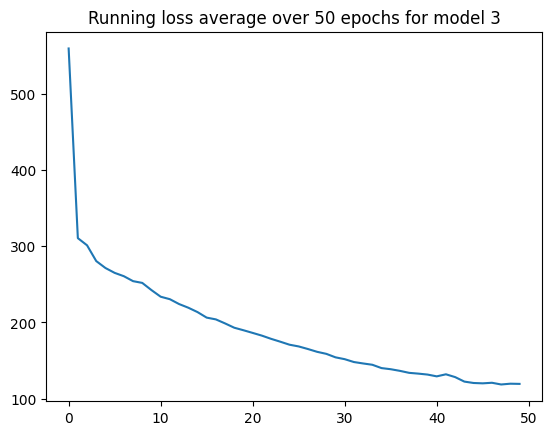

In [ ]:
plt.plot(losses)
plt.title("Running loss average over 50 epochs for model 3")
plt.show()

In [ ]:
validation_dataset = TensorDataset(X_val, y_val)
validation_dl = DataLoader(dataset=validation_dataset, batch_size=12, shuffle=False)

In [ ]:
import random

In [ ]:
def test_validation_avgloss(model, dataloader, batch_size):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    labels = []
    predictions = []
    with torch.no_grad():
        for i, (x,y) in enumerate(dataloader):
            a = model.forward_prop(x.unsqueeze(1))
            loss = loss_function(a, y)
            labels.append(y)
            predictions.append(a)
            num_samples += batch_size
            total_loss += loss.item() * batch_size
    average_loss = total_loss/num_samples
    return average_loss

In [ ]:
validation_avgloss = test_validation_avgloss(model=model, dataloader=validation_dl, batch_size=12)

print("(Validation) Average loss: ", validation_avgloss)

(Validation) Average loss:  108.57145401925752


Feed X-test into the model and sample an output to graph

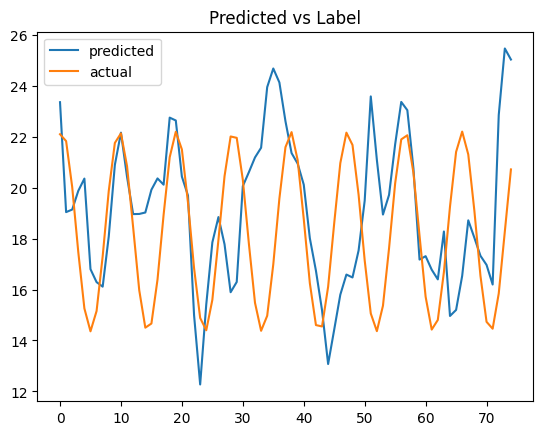

In [ ]:
single_item_dl = DataLoader(dataset=validation_dl.dataset, batch_size=1, shuffle=True)
random_batch = next(iter(single_item_dl))

feature, label = random_batch
feature = feature.T.squeeze(1)
feature = feature.reshape(1,1, 6000)
prediction = model.forward_prop(feature)

label = label.cpu().detach().numpy().reshape(-1)
prediction = prediction.cpu().detach().numpy().reshape(-1)

plt.title("Predicted vs Label")

plt.plot(prediction, label="predicted")
plt.plot(label, label="actual")
plt.legend()
plt.show()

Now, let's do some fourrier analysis on this signal

The first intention is that if we can apply a fourrier to the label itself and ask the model to learn the actual activation times as a wave

Let's take the label variable from the last cell, apply a fourier transform and plot the noisy graph and PSD graphs, and then undo the transform using the new frequencies to reconstruct the original

Now let's graph the prominent frequencies

Now, let's undo the fft to reconstruct the image and see how close the reconstructed wave is to the actual label

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_dl = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

In [ ]:
test_avgloss = test_validation_avgloss(model=model, dataloader=test_dl, batch_size=8)
print("(Test) Average loss: ", test_avgloss)

(Test) Average loss:  104.987813164577


In [ ]:
# x = X_test.squeeze(0)
# print(x.shape)
# difference = round(np.mean(np.abs(y_test - model.forward_prop(x.unsqueeze(1)))), 2)
# print("(Test) Mean absolute error: ", difference)

torch.Size([4836, 6000])


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.73 GiB. GPU 0 has a total capacty of 11.91 GiB of which 1.64 GiB is free. Process 3439427 has 10.00 MiB memory in use. Including non-PyTorch memory, this process has 10.25 GiB memory in use. Of the allocated memory 9.91 GiB is allocated by PyTorch, and 25.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF